# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from fvcore.nn import FlopCountAnalysis, flop_count_table
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
# DATASET = "CIFAR10"
# DATASET = "CIFAR100"
DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 1000
SCHEDULER_PARIENCE = 10
COOLDOWN = 25

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 40
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'MyResNet34_256_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  ImageNet2012
- Length of Train Set :  1281167
- Length of Valid Set :  50000
- Count of Classes :  1000
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      RandomShortestSize(min_size=[256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 44

# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="B"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-34 for ImageNet2012 is loaded.


In [8]:
# model.named_modules

In [9]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [10]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [11]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [12]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_path=file_path)

## (4) Define Learning Rate schedualer

In [13]:
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=SCHEDULER_PARIENCE,
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=COOLDOWN,
)


## (5) Define AMP scaler

In [14]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [15]:
if os.path.exists(file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
MyResNet34_256_SGD
Current epoch is 42
Current learning rate: 0.010000000000000002


In [16]:
optimizer.param_groups[0]["lr"]

0.010000000000000002

In [17]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [18]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 43/1000] :


train: 100%|██████████| 5005/5005 [24:01<00:00,  3.47it/s]


Train Loss: 0.0004 | Train Acc: 57.34%


eval: 100%|██████████| 196/196 [01:15<00:00,  2.60it/s]


Valid Loss: 1.6084 | Valid Acc: 66.86%
updated best eval loss : 1.60838349376406
--------------------------------------------------
[Epoch 44/1000] :


train:   0%|          | 16/5005 [00:05<30:32,  2.72it/s] 


KeyboardInterrupt: 

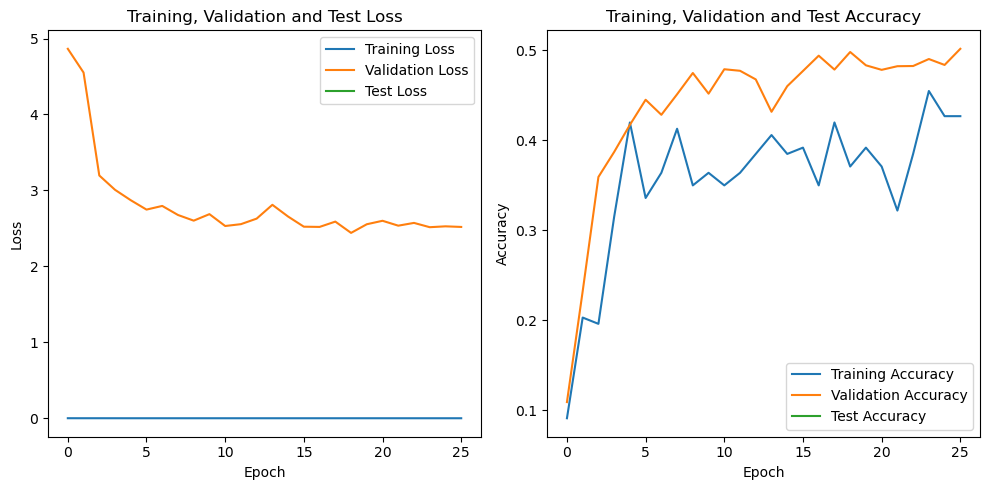

In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

1 epoch: train_loss=0.0010, train_acc=0.0909, valid_loss=4.8649, valid_acc=0.1089, lr=0.1000
2 epoch: train_loss=0.0007, train_acc=0.2028, valid_loss=4.5521, valid_acc=0.2320, lr=0.1000
3 epoch: train_loss=0.0008, train_acc=0.1958, valid_loss=3.1969, valid_acc=0.3590, lr=0.1000
4 epoch: train_loss=0.0007, train_acc=0.3147, valid_loss=3.0082, valid_acc=0.3868, lr=0.1000
5 epoch: train_loss=0.0006, train_acc=0.4196, valid_loss=2.8712, valid_acc=0.4169, lr=0.1000
6 epoch: train_loss=0.0006, train_acc=0.3357, valid_loss=2.7477, valid_acc=0.4448, lr=0.1000
7 epoch: train_loss=0.0006, train_acc=0.3636, valid_loss=2.7961, valid_acc=0.4281, lr=0.1000
8 epoch: train_loss=0.0005, train_acc=0.4126, valid_loss=2.6769, valid_acc=0.4509, lr=0.1000
9 epoch: train_loss=0.0006, train_acc=0.3497, valid_loss=2.6023, valid_acc=0.4745, lr=0.1000
10 epoch: train_loss=0.0006, train_acc=0.3636, valid_loss=2.6879, valid_acc=0.4516, lr=0.1000
11 epoch: train_loss=0.0006, train_acc=0.3497, valid_loss=2.5318, val

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))